<a href="https://colab.research.google.com/github/stee1011/Internship_Tasks/blob/main/Copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def get_data_loaders(batch_size=128):
    """Create data loaders for CIFAR-10 dataset"""
    print("Preparing CIFAR-10 dataset...")

    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

    # Simple transform for testing
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_loader, test_loader

In [ ]:
def visualize_sample_images(train_loader):
    """Display sample images from the dataset"""
    # Get a batch of training data
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    # Denormalize for visualization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    plt.figure(figsize=(12, 8))
    for i in range(20):
        plt.subplot(4, 5, i + 1)

        # Denormalize image
        img = images[i]
        img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        # Convert to numpy and transpose for matplotlib
        img_np = img.numpy().transpose(1, 2, 0)

        plt.imshow(img_np)
        plt.title(f'{class_names[labels[i]]}')
        plt.axis('off')

    plt.suptitle('Sample Images from CIFAR-10 Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
def create_resnet18_model():
    """Create ResNet18 model with transfer learning"""
    print("Creating ResNet18 model with transfer learning...")

    # Load pre-trained ResNet18
    model = torchvision.models.resnet18(pretrained=True)

    # Freeze all layers except the final classifier
    for param in model.parameters():
        param.requires_grad = False


    # ResNet18 has 512 features in the final layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)  # 10 classes for CIFAR-10

    # Only the final layer will be trained
    model.fc.requires_grad = True

    # Move model to device
    model = model.to(device)

    print(f"Model moved to {device}")
    return model

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=20):
    """Train the model"""
    print("Starting training...")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training history
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct_train / total_train

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Evaluation phase
        test_acc = evaluate_model(model, test_loader, verbose=False)
        test_accuracies.append(test_acc)

        # Update learning rate
        scheduler.step()

        # Save best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Loss: {epoch_loss:.4f}, '
              f'Train Acc: {epoch_acc:.2f}%, '
              f'Test Acc: {test_acc:.2f}%, '
              f'Time: {epoch_time:.2f}s')

    print(f'Best Test Accuracy: {best_test_acc:.2f}%')

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, train_accuracies, test_accuracies


In [ ]:
def evaluate_model(model, test_loader, verbose=True):
    """Evaluate the model"""
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total

    if verbose:
        print(f'Test Accuracy: {accuracy:.2f}%')
        print('\nClassification Report:')
        print(classification_report(all_labels, all_predictions,
                                  target_names=class_names))

    return accuracy


In [ ]:
def plot_training_history(train_losses, train_accuracies, test_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_loader):
    """Plot confusion matrix"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def visualize_predictions(model, test_loader):
    """Visualize some predictions"""
    model.eval()

    # Get one batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Move back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()

    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    plt.figure(figsize=(15, 10))

    for i in range(16):
        plt.subplot(4, 4, i + 1)

        # Denormalize image
        img = images[i]
        img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img_np = img.numpy().transpose(1, 2, 0)

        plt.imshow(img_np)

        # Color code: green for correct, red for incorrect
        color = 'green' if predicted[i] == labels[i] else 'red'
        symbol = '✓' if predicted[i] == labels[i] else '✗'

        confidence = probabilities[i][predicted[i]] * 100
        plt.title(f'{symbol} True: {class_names[labels[i]]}\n'
                 f'Pred: {class_names[predicted[i]]} ({confidence:.1f}%)',
                 color=color, fontsize=9)
        plt.axis('off')

    plt.suptitle('Predictions: Green=Correct, Red=Incorrect', fontsize=14)
    plt.tight_layout()
    plt.show()

CIFAR-10 Classification with PyTorch ResNet18
Preparing CIFAR-10 dataset...


100%|██████████| 170M/170M [00:08<00:00, 19.0MB/s]


Training samples: 50000
Test samples: 10000


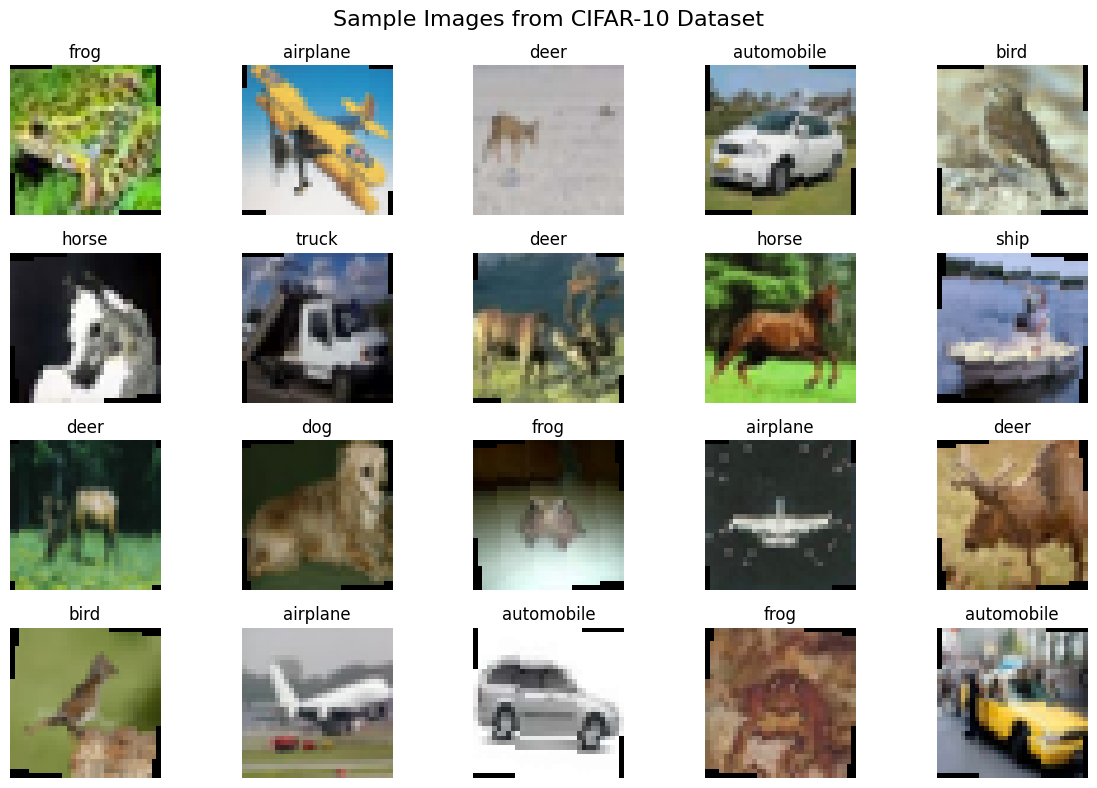

Creating ResNet18 model with transfer learning...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


Model moved to cuda
Starting training...


Epoch 1/15: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s, Loss=1.8609, Acc=34.33%]


Epoch 1/15: Loss: 1.8609, Train Acc: 34.33%, Test Acc: 40.41%, Time: 23.70s


Epoch 2/15: 100%|██████████| 391/391 [00:21<00:00, 18.05it/s, Loss=1.7270, Acc=39.30%]


Epoch 2/15: Loss: 1.7270, Train Acc: 39.30%, Test Acc: 41.79%, Time: 24.28s


Epoch 3/15: 100%|██████████| 391/391 [00:21<00:00, 18.42it/s, Loss=1.6968, Acc=40.42%]


Epoch 3/15: Loss: 1.6968, Train Acc: 40.42%, Test Acc: 42.32%, Time: 23.81s


Epoch 4/15: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s, Loss=1.6879, Acc=40.93%]


Epoch 4/15: Loss: 1.6879, Train Acc: 40.93%, Test Acc: 42.34%, Time: 23.51s


Epoch 5/15: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s, Loss=1.6817, Acc=41.22%]


Epoch 5/15: Loss: 1.6817, Train Acc: 41.22%, Test Acc: 42.64%, Time: 23.55s


Epoch 6/15: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s, Loss=1.6783, Acc=41.40%]


Epoch 6/15: Loss: 1.6783, Train Acc: 41.40%, Test Acc: 43.61%, Time: 22.20s


Epoch 7/15: 100%|██████████| 391/391 [00:21<00:00, 18.55it/s, Loss=1.6743, Acc=41.31%]


Epoch 7/15: Loss: 1.6743, Train Acc: 41.31%, Test Acc: 42.77%, Time: 23.49s


Epoch 8/15: 100%|██████████| 391/391 [00:20<00:00, 19.26it/s, Loss=1.6514, Acc=42.40%]


Epoch 8/15: Loss: 1.6514, Train Acc: 42.40%, Test Acc: 43.73%, Time: 22.79s


Epoch 9/15: 100%|██████████| 391/391 [00:19<00:00, 19.85it/s, Loss=1.6391, Acc=42.99%]


Epoch 9/15: Loss: 1.6391, Train Acc: 42.99%, Test Acc: 44.03%, Time: 23.03s


Epoch 10/15: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s, Loss=1.6441, Acc=42.77%]


Epoch 10/15: Loss: 1.6441, Train Acc: 42.77%, Test Acc: 44.06%, Time: 21.95s


Epoch 11/15: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s, Loss=1.6374, Acc=42.70%]


Epoch 11/15: Loss: 1.6374, Train Acc: 42.70%, Test Acc: 43.84%, Time: 24.19s


Epoch 12/15: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=1.6365, Acc=42.89%]


Epoch 12/15: Loss: 1.6365, Train Acc: 42.89%, Test Acc: 43.65%, Time: 23.69s


Epoch 13/15: 100%|██████████| 391/391 [00:20<00:00, 19.34it/s, Loss=1.6331, Acc=42.89%]


Epoch 13/15: Loss: 1.6331, Train Acc: 42.89%, Test Acc: 43.87%, Time: 23.38s


Epoch 14/15: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s, Loss=1.6355, Acc=43.06%]


Epoch 14/15: Loss: 1.6355, Train Acc: 43.06%, Test Acc: 43.63%, Time: 22.49s


Epoch 15/15: 100%|██████████| 391/391 [00:20<00:00, 19.17it/s, Loss=1.6315, Acc=43.20%]


Epoch 15/15: Loss: 1.6315, Train Acc: 43.20%, Test Acc: 43.96%, Time: 22.83s
Best Test Accuracy: 44.06%

FINAL EVALUATION
Test Accuracy: 44.06%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.42      0.46      0.44      1000
  automobile       0.50      0.47      0.48      1000
        bird       0.36      0.40      0.38      1000
         cat       0.39      0.33      0.36      1000
        deer       0.44      0.46      0.45      1000
         dog       0.43      0.42      0.42      1000
        frog       0.54      0.47      0.50      1000
       horse       0.48      0.44      0.45      1000
        ship       0.39      0.59      0.47      1000
       truck       0.53      0.38      0.44      1000

    accuracy                           0.44     10000
   macro avg       0.45      0.44      0.44     10000
weighted avg       0.45      0.44      0.44     10000



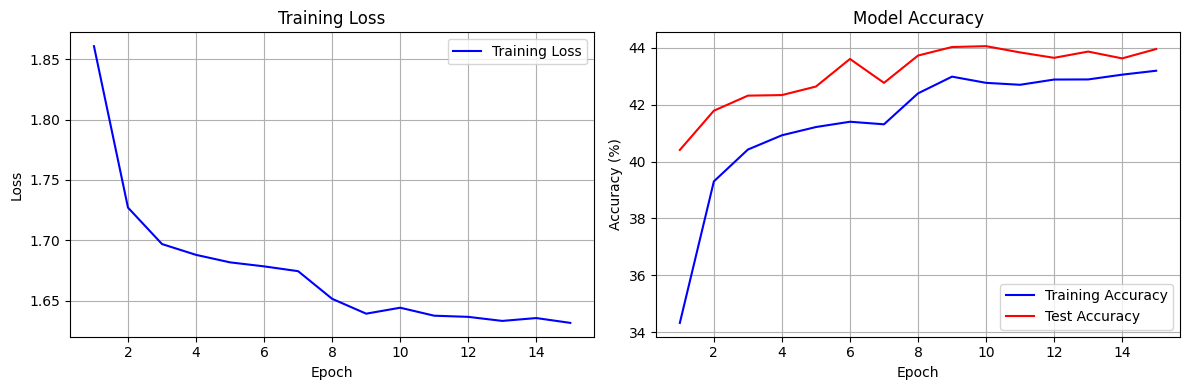

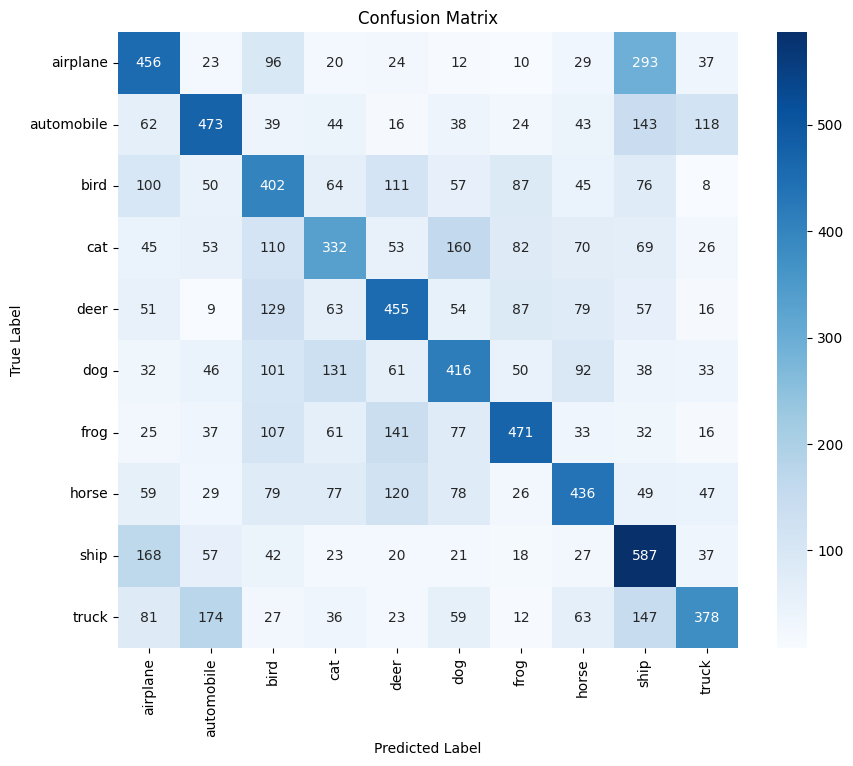

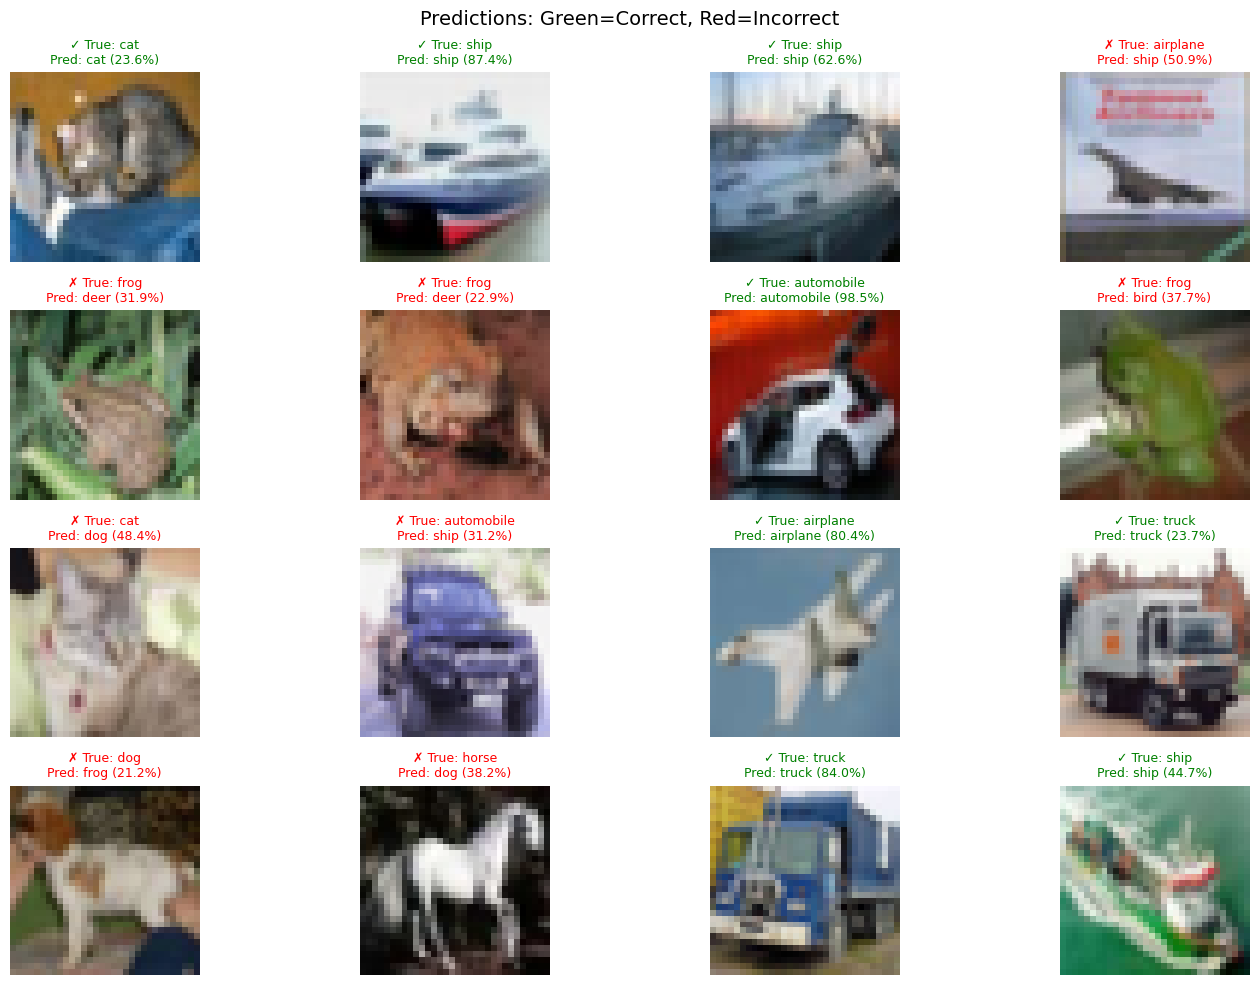


Training complete! Key features:
• Transfer learning with pre-trained ResNet18
• Data augmentation for better generalization
• Learning rate scheduling
• Best model checkpointing
• Comprehensive evaluation and visualization


In [ ]:
def main():
    """Main function to run the complete pipeline"""
    print("=" * 60)
    print("CIFAR-10 Classification with PyTorch ResNet18")
    print("=" * 60)

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Get data loaders
    train_loader, test_loader = get_data_loaders(batch_size=128)

    # Visualize sample images
    visualize_sample_images(train_loader)

    # Create model
    model = create_resnet18_model()

    # Train model
    model, train_losses, train_accuracies, test_accuracies = train_model(
        model, train_loader, test_loader, num_epochs=15
    )

    # Final evaluation
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)
    evaluate_model(model, test_loader)

    # Plot results
    plot_training_history(train_losses, train_accuracies, test_accuracies)
    plot_confusion_matrix(model, test_loader)
    visualize_predictions(model, test_loader)

    print("\nTraining complete! Key features:")
    print("• Transfer learning with pre-trained ResNet18")
    print("• Data augmentation for better generalization")
    print("• Learning rate scheduling")
    print("• Best model checkpointing")
    print("• Comprehensive evaluation and visualization")

    return model

# Run the complete pipeline
if __name__ == "__main__":
    model = main()